### data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

R_flat = pd.read_csv("result/result_R.csv")

I_len = R_flat["generator"].nunique()
T_len = R_flat["time"].nunique() 
S_len = R_flat["scenario"].nunique()

R = R_flat.pivot_table(
    values="value",
    index="generator",
    columns=["time", "scenario"]
).to_numpy()
R = R.reshape(I_len, T_len, S_len)

I, T, S = R.shape
prob = np.array([1 / S for _ in range(S)])

price_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_price.csv"
)
price_q["Time"] = pd.to_datetime(price_q["Time"], format="%Y-%m-%d %H:%M")

price_q["Hour"] = price_q["Time"].dt.floor("h")
price_h = price_q.groupby("Hour").mean(numeric_only=True)

price = price_h.iloc[: S * T]

P_DA = np.array(
    [sum(price["Price"].iloc[t + s * T] for s in range(S)) / S * 1.2 for t in range(T)]
)
P_RT = np.array([[price["Price"].iloc[t + s * T] for s in range(S)] for t in range(T)])
P_PN = np.array(
    [sum(price["Price"].iloc[t + s * T] for s in range(S)) / S * 2 for t in range(T)]
)

only_profit = np.array(pd.read_csv("result/result_only_profit.csv"))

### settlement model

In [196]:
set = gp.Model("Settlement")
# set.Params.OutputFlag = 0
# set.setParam('TimeLimit', 3600)
# set.setParam('Presolve', 0)
set.setParam("PoolSolutions", 15)
set.setParam("PoolSearchMode", 2)
set.setParam("PoolGap", 0.05)

x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
y_plus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
y_minus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
M_y = max(R[i, t, s] for i in range(I) for t in range(T) for s in range(S))
z_y = set.addVars(I, T, S, vtype=GRB.BINARY, name="z_y")

d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
d_max_H = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="d_max_H")
e_plus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_plus")
e_minus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_minus")
M_e = max(sum(R[i, t, s] for i in range(I)) for t in range(T) for s in range(S))
z_e = set.addVars(T, S, vtype=GRB.BINARY, name="z_e") 
set.update()

# obj. func.
obj = gp.quicksum(
    P_DA[t] * x[i, t] for i in range(I) for t in range(T)
) + gp.quicksum(
    prob[s] * (P_RT[t, s] * e_plus[i, t, s] - P_PN[t] * e_minus[i, t, s])
    for i in range(I) for t in range(T) for s in range(S)
)

set.setObjective(obj, GRB.MAXIMIZE)

Set parameter PoolSolutions to value 15
Set parameter PoolSearchMode to value 2
Set parameter PoolGap to value 0.05


In [197]:
# x로 y+, y- 결정 지어주기
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(R[i, t, s] - x[i, t] == y_plus[i, t, s] - y_minus[i, t, s])

# y+, y- 둘 중 하나는 0이어야함
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(y_plus[i, t, s] <= M_y * z_y[i, t, s])
            set.addConstr(y_minus[i, t, s] <= M_y * (1 - z_y[i, t, s]))

# rt 조건
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(y_plus[i, t, s] <= R[i, t, s])

# sum e+, sum e- 결정 지어주기
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - gp.quicksum(x[i, t] for i in range(I)) 
                          == gp.quicksum(e_plus[i, t, s] for i in range(I)) - gp.quicksum(e_minus[i, t, s] for i in range(I)))

# sum e+, sum e- 둘 중 하나는 0이어야 함
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(gp.quicksum(e_plus[i, t, s] for i in range(I)) <= M_e * z_e[t, s])
            set.addConstr(gp.quicksum(e_minus[i, t, s] for i in range(I)) <= M_e * (1 - z_e[t, s]))

# sum e+ <= sum R
for t in range(T):
    for s in range(S):
        set.addConstr(gp.quicksum(e_plus[i, t, s] for i in range(I)) <= gp.quicksum(R[i, t, s] for i in range(I)))

# e+, e- 정의
for i in range(I):
    for t in range(T):
        for s in range(S):
            # e_plus: 초과량에서 준 양을 뺀 것
            set.addConstr(
                e_plus[i,t,s] == y_plus[i,t,s] - gp.quicksum(d[i,j,t,s] for j in range(I) if j != i)
            )
            # e_minus: 부족량에서 받은 양을 뺀 것
            set.addConstr(
                e_minus[i,t,s] == y_minus[i,t,s] - gp.quicksum(d[j,i,t,s] for j in range(I) if j != i)
            )

# 전력 이동 제한
for i in range(I):
    for t in range(T):
        for s in range(S):
            # 본인이 주는 양은 자신의 y+을 넘을 수 없음
            set.addConstr(
                gp.quicksum(d[i, j, t, s] for j in range(I) if j != i)
                <= y_plus[i, t, s]
            )
            # 본인이 받는 양은 자신의 y-을 넘을 수 없음
            set.addConstr(
                gp.quicksum(d[j, i, t, s] for j in range(I) if j != i)
                <= y_minus[i, t, s]
            )

# 자기 자신과의 거래 방지
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(d[i, i, t, s] == 0)

# # d_max_H 정의
# for t in range(T):
#     for s in range(S):
#         for i in range(I):
#                 set.addConstr(
#                     d_max_H[t, s] >= gp.quicksum(d[i, j, t, s] for j in range(I) if j != i)
#             )

# # d_max 제한
# for t in range(T):
#     for s in range(S):
#         set.addConstr(
#             d_max_H[t, s] <= 0.3 * gp.quicksum(y_plus[i, t, s] for i in range(I))
#         )

In [198]:
set.optimize()

if set.status == GRB.OPTIMAL:
    x_vals = np.array([[x[i, t].x for t in range(T)] for i in range(I)])
    y_plus_vals = np.array(
        [[[y_plus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    y_minus_vals = np.array(
        [[[y_minus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    d_vals = np.array(
        [
            [[[d[i, j, t, s].x for s in range(S)] for t in range(T)] for j in range(I)]
            for i in range(I)
        ]
    )
    e_plus_vals = np.array(
        [[[e_plus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    e_minus_vals = np.array(
        [[[e_minus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    print("\n- - - - - - - - - - - - - - - - - - - - - - - - -")
    print("Optimal solution found!")
    print(set.objVal)
    print(f"Optimality Gap: {set.MIPGap}")
else:
    print("\nNo optimal solution found.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
PoolSolutions  15
PoolSearchMode  2
PoolGap  0.05

Optimize a model with 87120 rows, 109680 columns and 748800 nonzeros
Model fingerprint: 0x0b1f875c
Variable types: 101760 continuous, 7920 integer (7920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [3e-04, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 9e+01]
Presolve removed 71978 rows and 77898 columns
Presolve time: 0.25s
Presolved: 15142 rows, 31782 columns, 81901 nonzeros
Variable types: 23862 continuous, 7920 integer (7920 binary)

Root relaxation: objective 1.085835e+04, 10754 iterations, 0.13 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

### 결과 분석

#### 수익 분석

In [199]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for i in range(I):
    for t in range(T):
        total_da_profit_obj += P_DA[t] * x[i, t].x

# Real-time 수익 비교
total_rt_profit_obj = 0
for i in range(I):
    for t in range(T):
        for s in range(S):
            rt_profit_obj = P_RT[t, s] * e_plus[i, t, s].x
            total_rt_profit_obj += 1 / S * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for i in range(I):
    for t in range(T):
        for s in range(S):
            penalty_cost_obj = P_PN[t] * e_minus[i, t, s].x
            total_penalty_cost_obj += 1 / S * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = (
    total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj
)

# 결과 출력
print(f"DA: {total_da_profit_obj:.2f}")
print(f"RT: {total_rt_profit_obj:.2f}")
print(f"Penalty: {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")

DA: 8763.45
RT: 2531.08
Penalty: 636.14
목적 함수 기반 총 이익 (_obj): 10658.40


#### 하루 aggregated 커밋량 분석

In [200]:
for t in range(T):
    avg_e_plus = sum(e_plus_vals[i, t, s] for i in range(I) for s in range(S)) / S
    avg_e_minus = sum(e_minus_vals[i, t, s] for i in range(I) for s in range(S)) / S
    print(f"[시간 {t}] x: {sum(x_vals[i, t] for i in range(I)):.3f}, e+: {avg_e_plus:.3f}, e-: {avg_e_minus:.3f}")

total_x = sum(x_vals[i, t] for i in range(I) for t in range(T))
print(f"총 하루 commitment: {total_x:.3f}")

[시간 0] x: 0.000, e+: 0.000, e-: 0.000
[시간 1] x: 0.000, e+: 0.000, e-: 0.000
[시간 2] x: 0.000, e+: 0.000, e-: 0.000
[시간 3] x: 0.000, e+: 0.000, e-: 0.000
[시간 4] x: 0.000, e+: 0.000, e-: 0.000
[시간 5] x: 0.000, e+: 0.000, e-: 0.000
[시간 6] x: 0.000, e+: 0.000, e-: 0.000
[시간 7] x: 0.000, e+: 0.000, e-: 0.000
[시간 8] x: 0.239, e+: 1.536, e-: 0.044
[시간 9] x: 7.534, e+: 4.970, e-: 0.658
[시간 10] x: 22.145, e+: 8.147, e-: 0.857
[시간 11] x: 35.440, e+: 10.946, e-: 0.962
[시간 12] x: 46.338, e+: 9.753, e-: 2.191
[시간 13] x: 46.237, e+: 13.172, e-: 2.081
[시간 14] x: 39.880, e+: 11.228, e-: 0.932
[시간 15] x: 25.067, e+: 9.817, e-: 1.115
[시간 16] x: 12.453, e+: 7.509, e-: 1.187
[시간 17] x: 2.213, e+: 3.310, e-: 0.303
[시간 18] x: 0.000, e+: 0.362, e-: 0.000
[시간 19] x: 0.000, e+: 0.000, e-: 0.000
[시간 20] x: 0.000, e+: 0.000, e-: 0.000
[시간 21] x: 0.000, e+: 0.000, e-: 0.000
[시간 22] x: 0.000, e+: 0.000, e-: 0.000
[시간 23] x: 0.000, e+: 0.000, e-: 0.000
총 하루 commitment: 237.547


#### exchange process

In [201]:
for t in range(13,14):
    x_sum = sum(x_vals[i, t] for i in range(I))

    for s in range(S):
        y_plus_sum = sum(y_plus_vals[i, t, s] for i in range(I))
        y_minus_sum = sum(y_minus_vals[i, t, s] for i in range(I))

        e_plus_sum = sum(e_plus_vals[i, t, s] for i in range(I))
        e_minus_sum = sum(e_minus_vals[i, t, s] for i in range(I))

        R_sum = sum(R[i, t, s] for i in range(I))

        print(f"[t={t} s={s}]")

        print(f"x 합계: {x_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {x_vals[i,t]:.2f}", end=" ")
        print(")")

        print(f"R 합계: {R_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {R[i, t, s]:.2f}", end=" ")
        print(")")

        print(f"y+ 합계: {y_plus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {y_plus_vals[i,t,s]:.2f}", end=" ")
        print(")")

        print(f"y- 합계: {y_minus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {y_minus_vals[i,t,s]:.2f}", end=" ")
        print(")")

        print(f"e+ 합계: {e_plus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {e_plus_vals[i,t,s]:.2f}", end=" ")
        print(")")

        print(f"e- 합계: {e_minus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {e_minus_vals[i,t,s]:.2f}", end=" ")
        print(")")

        print("거래 내역:")
        for i in range(I):
            for j in range(I):
                if d_vals[i, j, t, s] > 1e-6:
                    print(
                        f"발전기 {i}가 발전기 {j}에게 {d_vals[i,j,t,s]:.2f} 전력을 줌"
                    )
        print()

[t=13 s=0]
x 합계: 46.24 ([0] 4.09 [1] 2.82 [2] 4.36 [3] 5.30 [4] 3.72 [5] 5.09 [6] 2.79 [7] 7.72 [8] 5.23 [9] 5.13 )
R 합계: 51.25 ([0] 3.58 [1] 0.00 [2] 12.85 [3] 9.30 [4] 0.00 [5] 12.12 [6] 1.94 [7] 5.22 [8] 0.00 [9] 6.25 )
y+ 합계: 20.65 ([0] 0.00 [1] 0.00 [2] 8.49 [3] 4.00 [4] 0.00 [5] 7.03 [6] 0.00 [7] 0.00 [8] 0.00 [9] 1.12 )
y- 합계: 15.63 ([0] 0.52 [1] 2.82 [2] 0.00 [3] 0.00 [4] 3.72 [5] 0.00 [6] 0.84 [7] 2.50 [8] 5.23 [9] 0.00 )
e+ 합계: 5.02 ([0] 0.00 [1] 0.00 [2] 1.01 [3] 4.00 [4] 0.00 [5] 0.00 [6] 0.00 [7] 0.00 [8] 0.00 [9] 0.00 )
e- 합계: 0.00 ([0] 0.00 [1] 0.00 [2] 0.00 [3] 0.00 [4] 0.00 [5] 0.00 [6] 0.00 [7] 0.00 [8] 0.00 [9] 0.00 )
거래 내역:
발전기 2가 발전기 0에게 0.52 전력을 줌
발전기 2가 발전기 1에게 2.40 전력을 줌
발전기 2가 발전기 4에게 3.72 전력을 줌
발전기 2가 발전기 6에게 0.84 전력을 줌
발전기 5가 발전기 1에게 0.42 전력을 줌
발전기 5가 발전기 7에게 2.50 전력을 줌
발전기 5가 발전기 8에게 4.11 전력을 줌
발전기 9가 발전기 8에게 1.12 전력을 줌

[t=13 s=1]
x 합계: 46.24 ([0] 4.09 [1] 2.82 [2] 4.36 [3] 5.30 [4] 3.72 [5] 5.09 [6] 2.79 [7] 7.72 [8] 5.23 [9] 5.13 )
R 합계: 51.95 ([0] 12.44 

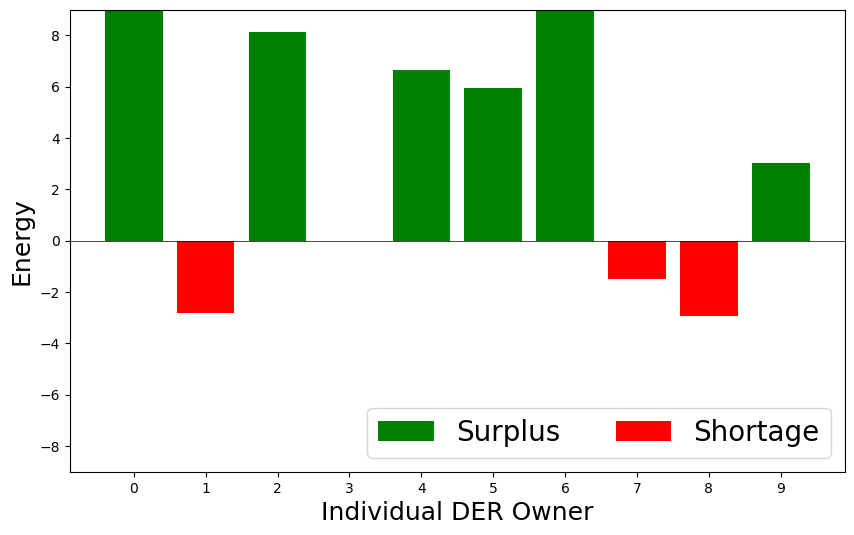

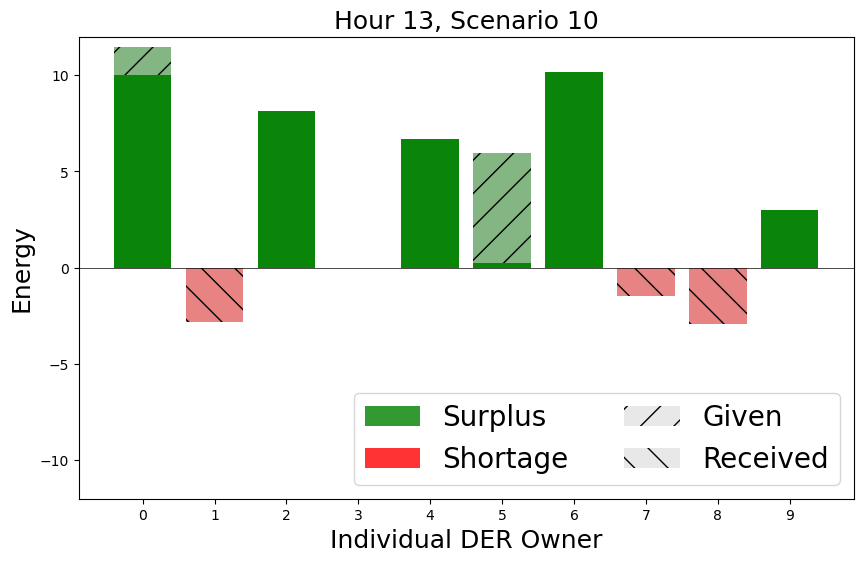

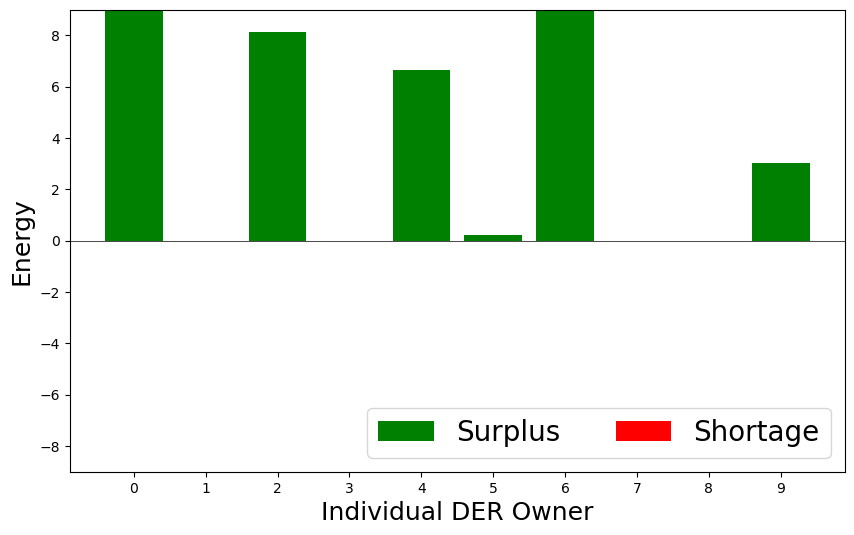

In [212]:
t_target = 13
s_target = 10

y_plus_values = [y_plus[i, t_target, s_target].x for i in range(I)]
y_minus_values = [-y_minus[i, t_target, s_target].x for i in range(I)]

der_indices = np.arange(I)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(der_indices, y_plus_values, color="green", label="Surplus")
ax.bar(der_indices, y_minus_values, color="red", label="Shortage")

ax.axhline(0, color="black", linewidth=0.5)
ax.set_xlabel("Individual DER Owner", fontsize=18)
ax.set_ylabel("Energy", fontsize=18)
ax.set_xticks(der_indices)  # DER owner 인덱스 설정
ax.legend(loc="lower right", fontsize=20, ncols=2)
ax.set_ylim(-9, 9)

# plt.title(f"Deviation from Commitment (Hour {t_target}, Scenario {s_target})")
plt.savefig(f"figure/fig_pool1.pdf", bbox_inches="tight")
plt.show()

# --------------------------------------------------------------------------------------

y_plus_values = np.array([y_plus[i, t_target, s_target].x for i in range(I)])
y_minus_values = np.array([-y_minus[i, t_target, s_target].x for i in range(I)])
d_ijts_values = np.array(
    [sum(d[i, j, t_target, s_target].x for j in range(I)) for i in range(I)]
)
d_jits_values = np.array(
    [-sum(d[j, i, t_target, s_target].x for j in range(I)) for i in range(I)]
)
der_indices = np.arange(I)
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(der_indices, y_plus_values, color="green", alpha=0.8)
ax.bar(
    der_indices,
    y_plus_values - d_ijts_values,
    color="green",
    label="Surplus",
    alpha=0.8,
)
ax.bar(der_indices, y_minus_values, color="red", label="Shortage", alpha=0.8)
ax.bar(
    der_indices,
    d_ijts_values,
    color="lightgray",
    alpha=0.5,
    hatch="/",
    bottom=y_plus_values - d_ijts_values,
    label="Given",
)
ax.bar(
    der_indices,
    d_jits_values,
    color="lightgray",
    alpha=0.5,
    hatch="\\",
    label="Received",
)

ax.axhline(0, color="black", linewidth=0.5)
ax.set_xlabel("Individual DER Owner", fontsize=18)
ax.set_ylabel("Energy", fontsize=18)
ax.set_xticks(der_indices)  # DER owner 인덱스 설정
ax.legend(loc="lower right", fontsize=20, ncols=2)
ax.set_ylim(-12, 12)

# plt.title(f"Settlement Phase (Hour {t_target}, Scenario {s_target})")
# plt.savefig(f"figure/fig_pool2.pdf", bbox_inches="tight")
plt.title(f"Hour {t_target}, Scenario {s_target}", fontsize=18)
plt.savefig(f"figure/fig_hdbal.pdf", bbox_inches="tight")
plt.show()

# --------------------------------------------------------------------------------------

e_plus_values = [e_plus[i, t_target, s_target].x for i in range(I)]
e_minus_values = [-e_minus[i, t_target, s_target].x for i in range(I)]

der_indices = np.arange(I)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(der_indices, e_plus_values, color="green", label="Surplus")
ax.bar(der_indices, e_minus_values, color="red", label="Shortage")

ax.axhline(0, color="black", linewidth=0.5)
ax.set_xlabel("Individual DER Owner", fontsize=18)
ax.set_ylabel("Energy", fontsize=18)
ax.set_xticks(der_indices)
ax.legend(loc="lower right", fontsize=20, ncols=2)
ax.set_ylim(-9, 9)

# plt.title(f"Final (Hour {t_target}, Scenario {s_target})")
plt.savefig(f"figure/fig_pool3.pdf", bbox_inches="tight")
plt.show()

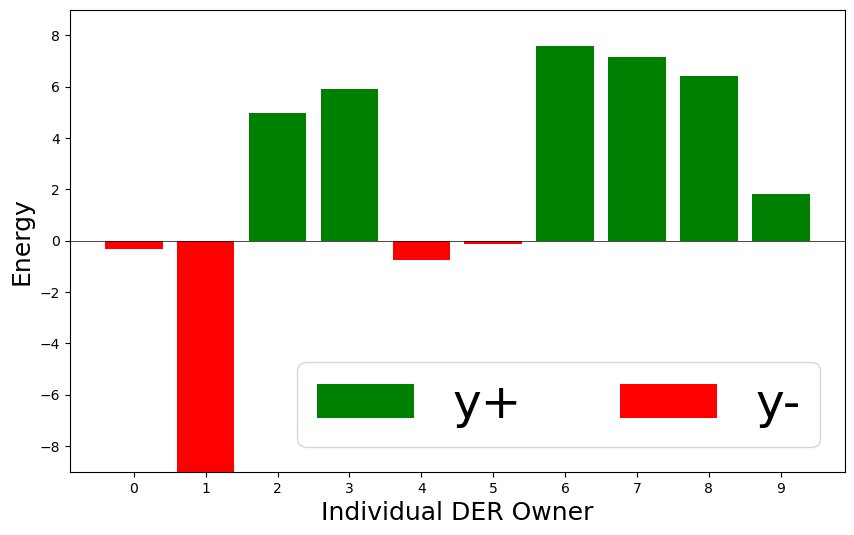

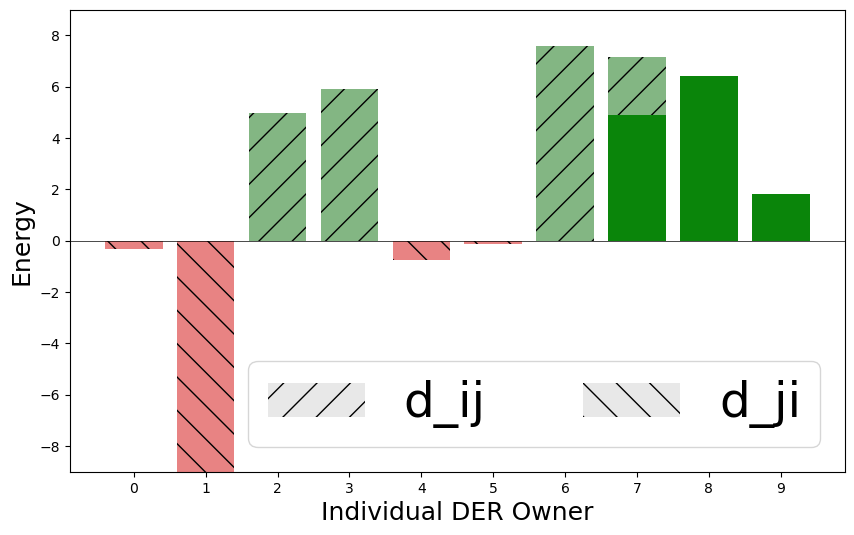

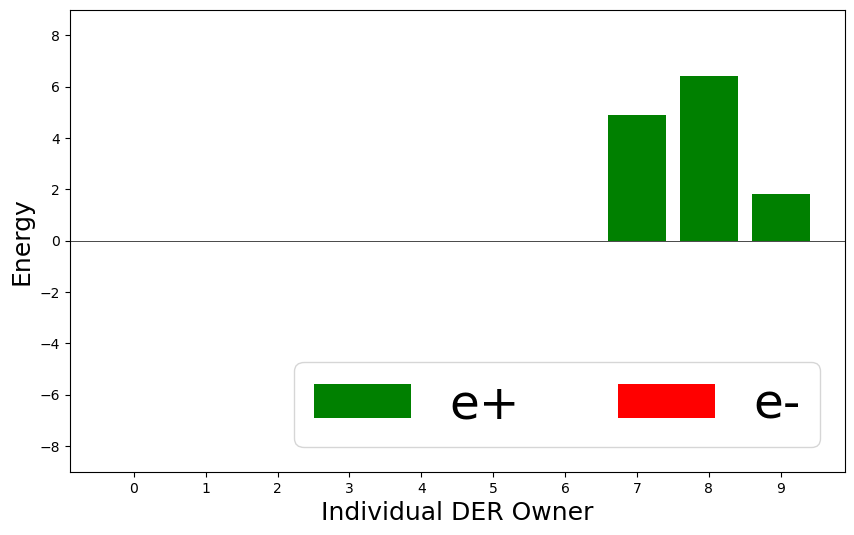

In [203]:
t_target = 15
s_target = 10

y_plus_values = [y_plus[i, t_target, s_target].x for i in range(I)]
y_minus_values = [-y_minus[i, t_target, s_target].x for i in range(I)]

der_indices = np.arange(I)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(der_indices, y_plus_values, color="green", label="y+")
ax.bar(der_indices, y_minus_values, color="red", label="y-")

ax.axhline(0, color="black", linewidth=0.5)
ax.set_xlabel("Individual DER Owner", fontsize=18)
ax.set_ylabel("Energy", fontsize=18)
ax.set_xticks(der_indices)  # DER owner 인덱스 설정
ax.legend(loc="lower right", fontsize=35, ncol=2)
ax.set_ylim(-9, 9)

# plt.title(f"Deviation from Commitment (Hour {t_target}, Scenario {s_target})")
plt.savefig(f"figure/fig_var1.pdf", bbox_inches="tight")
plt.show()

# --------------------------------------------------------------------------------------

y_plus_values = np.array([y_plus[i, t_target, s_target].x for i in range(I)])
y_minus_values = np.array([-y_minus[i, t_target, s_target].x for i in range(I)])
d_ijts_values = np.array(
    [sum(d[i, j, t_target, s_target].x for j in range(I)) for i in range(I)]
)
d_jits_values = np.array(
    [-sum(d[j, i, t_target, s_target].x for j in range(I)) for i in range(I)]
)
der_indices = np.arange(I)
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(der_indices, y_plus_values, color="green", alpha=0.8)
ax.bar(
    der_indices,
    y_plus_values - d_ijts_values,
    color="green",
    # label="Surplus",
    alpha=0.8,
)
ax.bar(der_indices, y_minus_values, color="red", alpha=0.8)
ax.bar(
    der_indices,
    d_ijts_values,
    color="lightgray",
    alpha=0.5,
    hatch="/",
    bottom=y_plus_values - d_ijts_values,
    label="d_ij",
)
ax.bar(
    der_indices,
    d_jits_values,
    color="lightgray",
    alpha=0.5,
    hatch="\\",
    label="d_ji",
)

ax.axhline(0, color="black", linewidth=0.5)
ax.set_xlabel("Individual DER Owner", fontsize=18)
ax.set_ylabel("Energy", fontsize=18)
ax.set_xticks(der_indices)  # DER owner 인덱스 설정
ax.legend(loc="lower right", fontsize=35, ncol=2)
ax.set_ylim(-9, 9)

# plt.title(f"Settlement Phase (Hour {t_target}, Scenario {s_target})")
plt.savefig(f"figure/fig_var2.pdf", bbox_inches="tight")
plt.show()

# --------------------------------------------------------------------------------------

e_plus_values = [e_plus[i, t_target, s_target].x for i in range(I)]
e_minus_values = [-e_minus[i, t_target, s_target].x for i in range(I)]

der_indices = np.arange(I)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(der_indices, e_plus_values, color="green", label="e+")
ax.bar(der_indices, e_minus_values, color="red", label="e-")

ax.axhline(0, color="black", linewidth=0.5)
ax.set_xlabel("Individual DER Owner", fontsize=18)
ax.set_ylabel("Energy", fontsize=18)
ax.set_xticks(der_indices)
ax.legend(loc="lower right", fontsize=35, ncol=2)
ax.set_ylim(-9, 9)

# plt.title(f"Final (Hour {t_target}, Scenario {s_target})")
plt.savefig(f"figure/fig_var3.pdf", bbox_inches="tight")
plt.show()

### 정산

In [204]:
total_der_profit = 0
der_profit = {}
for i in range(I):
    der_profit[i] = sum(P_DA[t] * x[i,t].x + sum(1/S * (P_RT[t,s] * e_plus[i,t,s].x - P_PN[t] * e_minus[i,t,s].x) for s in range(S)) for t in range(T))
    total_der_profit += der_profit[i]

print(f"\n모든 der의 profit 합계: {total_der_profit:.2f}")

print("\n최종 profit:")
for i, (profit, only) in enumerate(zip(der_profit.values(), only_profit.flatten())):
    increase_percentage = ((profit - only) / only) * 100
    print(f"[{i}] {profit:.2f} ({increase_percentage:.2f}%)")


모든 der의 profit 합계: 10658.40

최종 profit:
[0] 882.03 (-36.69%)
[1] 1337.01 (66.43%)
[2] 804.15 (-29.18%)
[3] 1544.74 (58.41%)
[4] 876.91 (5.12%)
[5] 1536.29 (101.47%)
[6] 761.23 (-35.55%)
[7] 843.05 (-13.05%)
[8] 1321.84 (113.98%)
[9] 751.14 (-13.95%)


In [205]:
only_value = pd.read_csv('result/result_only_obj.csv').values
only_profit = pd.read_csv('result/result_only_profit.csv').values
surplus = set.objVal - only_value[0] #

I, T, S = R.shape

R_proportion = R / R.sum(axis=1, keepdims=True) 
R_proportion = np.nan_to_num(R_proportion) 

R_proportion_P = np.multiply(R_proportion, P_DA[:, np.newaxis])

R_weighted = R_proportion_P.sum(axis=(1, 2)) 

R_weighted_normalized = R_weighted / R_weighted.sum() 

surplus_distribution = surplus * R_weighted_normalized  

final_profit = only_profit.flatten() + surplus_distribution

print("Surplus 분배 결과:")
for i, value in enumerate(surplus_distribution):
    print(f"[{i}]: {value:.2f}")

print("\n최종 Profit:")
for i, (profit, only) in enumerate(zip(final_profit, only_profit.flatten())):
    increase_percentage = ((profit - only) / only) * 100
    print(f"[{i}] {profit:.2f} ({increase_percentage:.2f}%)")

Surplus 분배 결과:
[0]: 110.24
[1]: 109.88
[2]: 110.73
[3]: 109.30
[4]: 109.11
[5]: 115.36
[6]: 111.12
[7]: 113.10
[8]: 111.50
[9]: 112.89

최종 Profit:
[0] 1503.35 (7.91%)
[1] 913.24 (13.68%)
[2] 1246.18 (9.75%)
[3] 1084.44 (11.21%)
[4] 943.28 (13.08%)
[5] 877.91 (15.13%)
[6] 1292.22 (9.41%)
[7] 1082.68 (11.66%)
[8] 729.25 (18.05%)
[9] 985.84 (12.93%)


In [206]:
d_given = np.array(
    [
        sum(
            sum(
                sum(d[i, j, t, s].x for t in range(T)) for j in range(I)
            ) for s in range(S)
        ) / S  # s의 평균 계산
        for i in range(I)
    ]
)

In [207]:
d_given
total_sum = np.sum(d_given)
d_given_ratios = d_given / total_sum if total_sum != 0 else np.zeros_like(d_given)
fourth = np.zeros(I)
fourth = set.objVal * d_given_ratios

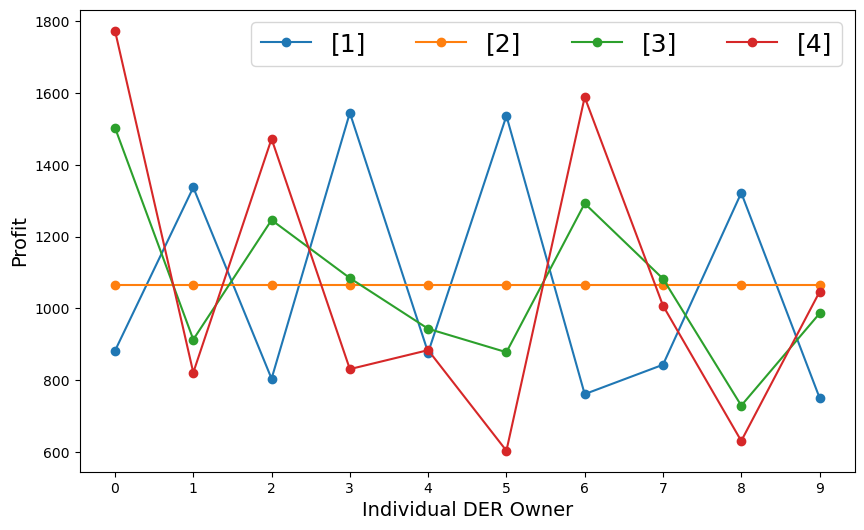

In [208]:
der_indices = np.arange(I)

fig, ax = plt.subplots(figsize=(10, 6))
der_profit_array = np.array(list(der_profit.values()))
first = der_profit_array
second = np.full(I, set.objVal/len(range(I)))

plt.plot(der_indices, first, marker="o", label="[1]")
plt.plot(der_indices, second, marker="o", label="[2]")
plt.plot(der_indices, final_profit, marker="o", label="[3]")
plt.plot(der_indices, fourth, marker="o", label="[4]")

ax.set_xlabel("Individual DER Owner", fontsize=14)
ax.set_ylabel("Profit", fontsize=14)
ax.set_xticks(der_indices)  # DER owner 인덱스 설정
ax.legend(loc="upper right", fontsize=18, ncols=4)

# plt.title(f"Profit Remuneration Approaches", fontsize=14)
plt.savefig(f"figure/fig_renum.pdf", bbox_inches="tight")
plt.show()

In [209]:
def plot_d_comparison(i):
    plt.figure(figsize=(8, 5))
    x = np.arange(len(only_profit))
    width = 0.3
    d = pd.read_csv(f"result/result_set{i}_d.csv")
    d0 = pd.read_csv(f"result/result_set1_d.csv")
    plt.bar(
        x - 0.5 * width,
        d0["set_d_given"],
        width,
        color="limegreen",
        # alpha = 0.8
    )
    plt.bar(
        x - 0.5 * width,
        d0["set_d_given"],
        width,
        label="given",
        color="lightgray",
        alpha=0.5,
        hatch="/",
    )
    plt.bar(
        x + 0.5 * width,
        d0["set_d_received"],
        width,
        color="red",
        # alpha=0.8,
    )
    plt.bar(
        x + 0.5 * width,
        d0["set_d_received"],
        width,
        label="received",
        color="lightgray",
        alpha=0.5,
        hatch="\\",
    )

    # 수직선(Vertical Line) 추가
    for a in range(len(x)):
        # base_given → given (초록색 세로선)
        plt.plot(
            [x - 0.5 * width, x - 0.5 * width],
            [d0["set_d_given"], d["set_d_given"]],
            color="gray",
            linestyle="-",
            linewidth=0.8,
        )
        # base_received → received (빨간색 세로선)
        plt.plot(
            [x + 0.5 * width, x + 0.5 * width],
            [d0["set_d_received"], d["set_d_received"]],
            color="gray",
            linestyle="-",
            linewidth=0.8,
        )
    plt.xticks(x)
    plt.xlabel("Individual DER Owners", fontsize=13)
    plt.ylabel("Energy", fontsize = 13)
    plt.ylim(0,18)
    plt.legend(fontsize=13)
    plt.savefig(f"figure/fig_ddbal.pdf", bbox_inches="tight")
    plt.show()

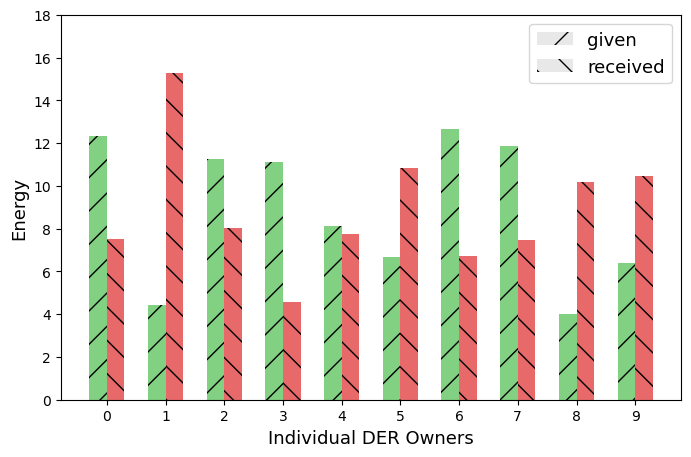

In [210]:
plot_d_comparison(1)